Documentation of ExAc analysis for targeting genetic variants for CRISPR experiments with AlleleAnalyzer.

In [1]:
import pandas as pd
import os
from pysam import VariantFile
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('aa_paper')
%matplotlib inline

# Reformat VCFs in parallel

Using a script called `get_gens_df.py` in `AlleleAnalyzer/generate_gens_dfs/get_gens_df.py`, we reformat the ExAc VCF in order to more easily annotate variants for whether they are near or in PAM sites. This is necessary because in ordinary VCF files, variants can have multiple alleles listed on one line, and these need to be split up for annotation based on each individual allele.

For the ExAc analysis, we parallelized this process using the BED file of regions where variants were called in the ExAc project, downloaded [here](ftp://ftp.broadinstitute.org/pub/ExAC_release/release0.3/resources/exome_calling_regions.v1.interval_list). These are in human reference genome hg19. This was run in parallel on QB3 at UCSF with the script `reformat_variants_exac.sh`, split into 3 individual scripts to accomodate the large number of jobs (QB3 only accepts submission of up to 100,000 jobs). 

In [6]:
test.head()

,chrom,pos,ref,alt
0,1,13372,G,C
1,1,13380,C,G
2,1,13382,C,G
3,1,13402,G,C
4,1,13404,G,A


In [2]:
regions = pd.read_csv('dat/exome_calling_regions.v1.interval_list', sep='\t',
                     comment='@', header=None, names=['chrom','start','stop','strand','name'])

regions['unique_name'] = 'region' + regions.index.astype(str)

# regions[['chrom','start','stop','unique_name']].to_csv('dat/exac_regions.bed',
#                                                       sep='\t', index=False, header=False)

len(regions)

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


207798

Check whether the reformatted variant files exist and look OK. All regions should have outputted a file, even if the file is empty. Identify any that didn't complete.

In [3]:
regions['gens_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/exac_data/exac_formatted_variants/' + regions['unique_name'] + '.h5'

regions['gens_complete'] = regions['gens_fname'].map(os.path.isfile)

# regions.query('~gens_complete')

# len(regions.query('~gens_complete'))

Some regions didn't complete, likely because of too many variants in one region.
Split each of the regions that didn't complete into 1kb chunks, except for the last chunk which will be <1kb to run these more efficiently.

In [30]:
non_completed = []
ix_ap = -1
for ix, row in regions.query('~gens_complete').iterrows():
#     print(row['unique_name'])
    counter = 0
    for num in range(row['start'], row['stop'], 1000):
        counter += 1
        if row['stop'] - num < 1000:
            ix_ap += 1
            to_append = pd.DataFrame({
            'chrom':row['chrom'],
            'start':num,
            'stop':row['stop'],
            'strand':row['strand'],
            'name':f'{row["name"]}',
            'unique_name':f'{row["unique_name"]}.{counter}'
                                 }, index=[ix_ap])
            non_completed.append(to_append)
        else:
            ix_ap += 1
            to_append = pd.DataFrame({
            'chrom':row['chrom'],
            'start':num,
            'stop':num + 1000,
            'strand':row['strand'],
            'name':f'{row["name"]}',
            'unique_name':f'{row["unique_name"]}.{counter}'
                                 }, index=[ix_ap])
            non_completed.append(to_append)

# concatenate the subsetted regions for the regions that didn't complete into one dataframe
non_comp_df = pd.concat(non_completed)

# save this data to a file for reference
# non_comp_df.to_csv('dat/exac_non_comp_regions_for_gens.tsv', sep='\t')

Identify the number of regions in order to determine how many jobs to run on QB3

In [52]:
len(non_comp_df)

69

Save a BED file in order to run these regions for reformatting.

In [51]:
# non_comp_df[['chrom','start','stop','unique_name']].to_csv('dat/exac_non_comp_regions_for_gens.bed',
#                                                           sep='\t', index=False, header=False)

Get list of filenames for subsetted regions of those that didn't complete in order to rerun these, and save them to a file

In [5]:
nc_2 = pd.read_csv('dat/exac_non_comp_regions_for_gens.tsv', sep='\t',
                  index_col=0)

nc_unique = nc_2['unique_name'].tolist()

# with open('dat/regions_nc.txt','w') as f:
#     for region in nc_unique:
#         f.write(region + '\n')

In [24]:
nc_unique_fnames = regions.query('unique_name in @nc_unique')['gens_fname'].tolist()

# with open('dat/non_completed_fnames.txt','w') as f:
#     for fname in nc_unique_fnames:
#         f.write(fname + '\n')

Make sure all the regions completed, now that the troublesome regions were subsetted.

In [6]:
non_complete = pd.read_csv('dat/exac_regions_rerun.bed',sep='\t',
                          header=None, names=['chrom','start','stop','unique_name'])

non_completed_unique = non_complete['unique_name'].tolist()

# make new regions dataframe merging the original regions that completed with the subsetted versions
# of the regions that did not

In [7]:
regions = pd.concat([regions.query('unique_name not in @non_completed_unique'),
                       nc_2])

regions['gens_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/exac_data/exac_formatted_variants/' + regions['unique_name'] + '.h5'

regions['gens_complete'] = regions['gens_fname'].map(os.path.isfile)

regions.query('~gens_complete')

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,chrom,gens_complete,gens_fname,name,start,stop,strand,unique_name


In [8]:
len(regions.query('~gens_complete'))

0

# Annotate variants in parallel

Using a script called `annot_variants.py` in `AlleleAnalyzer/preprocessing/annotate_variants/`, we annotate variants for whether they are near or in PAM sites. 

For the ExAc analysis, we parallelized this process using the BED file of regions where variants were called in the ExAc project, downloaded [here](ftp://ftp.broadinstitute.org/pub/ExAC_release/release0.3/resources/exome_calling_regions.v1.interval_list). These are in human reference genome hg19. This was run in parallel on QB3 at UCSF with the script `annotate_variants_exac.sh`, split into 3 individual scripts to accomodate the large number of jobs (QB3 only accepts submission of up to 100,000 jobs per script). For ther regions identified above that had to be subsetted, they were run with the script `annotate_variants_exac_rerun.sh`.

In [12]:
# regions['annots_fname'] = '/pollard/data/projects/AlleleAnalyzer_data/exac_data/exac_annotated_variants/' + \
# regions['unique_name'] + '.h5'
# regions['annots_file_exists'] = regions['annots_fname'].map(os.path.isfile)

# regions.to_csv('dat/exac_regions_w_filenames.tsv', sep='\t', index=False)

In [ ]:
regions = pd.read_csv('dat/exac_regions_w_filenames.tsv', sep='\t')

regions['chrom'] = regions['chrom'].astype(str)

for chrom in list(range(1,23)) + ['X','Y']:
    chrom = str(chrom)
#     regions.query('(chrom == @chrom) and (annots_file_exists)').to_csv(f'/pollard/data/projects/AlleleAnalyzer_data/exac_data/exac_regions_by_chrom/chr{chrom}_regions.tsv',
#                                           sep='\t', index=False)

Identify whether an annotation file was generated for the region in question. Not all regions will have files - if there were no variants, no file will be generated.

In [36]:
len(regions.query('~annots_file_exists'))

7278

Check the number of variants in each region, and make sure it agrees with the BCF. (Error and sanity checking)

In [40]:
n_vars_bcf = []
n_vars_annots = []

In [41]:
bcf_in = VariantFile('/pollard/data/genetics/ExAc/ExAC.r1.sites.vep.vcf.gz')

In [46]:
bcfin = bcf_in.fetch('1',13354,13689)

In [42]:
def n_vars(region):
    counter = 0
    for var in region:
        counter += 1
    return counter

Check to make sure numbers of variants in BCF and annotation files are similar. Annotation files will have more variants due to separating multi-allelic sites.

In [68]:
n_vars_bcf = []
n_vars_annots = []

for ix, row in regions.tail(20).iterrows():
    var_info = bcf_in.fetch(str(row['chrom']), row['start'], row['stop'])
    n_vars_bcf_ = n_vars(var_info)
    n_vars_bcf.append(n_vars_bcf_)
#     print(row['annots_fname'])
    if n_vars_bcf_ == 0:
        n_vars_annots.append(0)
    elif os.path.isfile(row['annots_fname']) == False:
        n_vars_annots.append('no file')
    else:
        df = pd.read_hdf(row['annots_fname'])
        n_vars_annots.append(len(df))
        
# regions['n_vars_bcf'] = n_vars_bcf
# regions['n_vars_annots'] = n_vars_annots

# Compile and plot results of variant annotation



The aggregation was done using the script `merge_annots_exac_parallel.sh` and `merge_annotations_exac.py`. Compilation of data into summary stats was done with `reformat_annots_exac.py`.

In [5]:
plotdf = pd.read_csv('dat/vars_near_in_df.tsv', sep='\t',
                    header=0, names=['cas','in PAM','near PAM','both'])

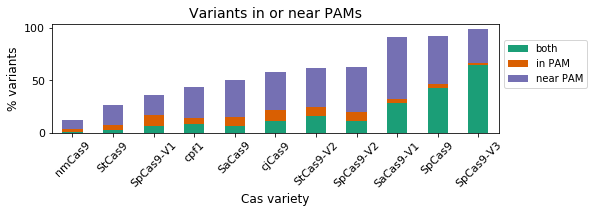

In [64]:
cas_dict={
    'SpCas9':'SpCas9',
    'SpCas9_VRER':'SpCas9-V1',
    'SpCas9_EQR':'SpCas9-V2',
    'SpCas9_VQR':'SpCas9-V3',
    'SpCas9_VQR_1':'SpCas9-V3',
    'SpCas9_VQR_2':'SpCas9-V3',
    'StCas9_1':'StCas9-V1',
    'StCas9_2':'StCas9-V2',
    'SaCas9':'SaCas9',
    'SaCas9_KKH':'SaCas9-V1',
    'nmCas9':'nmCas9',
    'cpf1':'cpf1',
    'StCas9_1':'StCas9-V1',
    'StCas9_2':'StCas9-V2',
    'cjCas9':'cjCas9'
}

# load pre-compiled data
plotdf = pd.read_csv('dat/vars_near_in_df.tsv', sep='\t',
                    header=0, names=['cas','in PAM','near PAM','both'])

#sort by total variants that generate allele-specific PAM site
plotdf['total'] = plotdf[['in PAM','near PAM','both']].sum(axis=1)
plotdf['Cas'] = plotdf['cas'].replace(cas_dict)
plotdf = plotdf.query('total > 0.0')

plotdf = plotdf.sort_values(by='total')

# munge for plotting
plotdf.index = plotdf['Cas']

plotdf = plotdf[['both','in PAM','near PAM']]
plotdf = plotdf.multiply(100.0)

plotdf.plot.bar(stacked='True', color=sns.color_palette('Dark2'), figsize=(8,2))
plt.legend(bbox_to_anchor=(1.0, 0.5))
# tickfont=16
plt.legend(bbox_to_anchor=(1.0, 0.9))
plt.xticks(rotation=45)
# labelfont = 18
plt.ylabel('% variants')
plt.xlabel('Cas variety')
plt.title('Variants in or near PAMs')
# plt.savefig('figures/fig_1b.pdf', dpi=300, bbox_inches='tight')

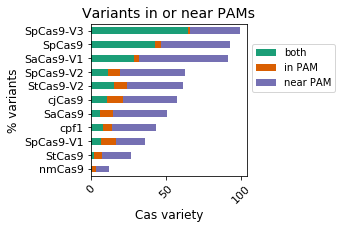

In [14]:
cas_dict={
    'SpCas9':'SpCas9',
    'SpCas9_VRER':'SpCas9-V1',
    'SpCas9_EQR':'SpCas9-V2',
    'SpCas9_VQR':'SpCas9-V3',
    'SpCas9_VQR_1':'SpCas9-V3',
    'SpCas9_VQR_2':'SpCas9-V3',
    'StCas9_1':'StCas9-V1',
    'StCas9_2':'StCas9-V2',
    'SaCas9':'SaCas9',
    'SaCas9_KKH':'SaCas9-V1',
    'nmCas9':'nmCas9',
    'cpf1':'cpf1',
    'StCas9_1':'StCas9-V1',
    'StCas9_2':'StCas9-V2',
    'cjCas9':'cjCas9'
}

# load pre-compiled data
plotdf = pd.read_csv('dat/vars_near_in_df.tsv', sep='\t',
                    header=0, names=['cas','in PAM','near PAM','both'])

#sort by total variants that generate allele-specific PAM site
plotdf['total'] = plotdf[['in PAM','near PAM','both']].sum(axis=1)
plotdf['Cas'] = plotdf['cas'].replace(cas_dict)
plotdf = plotdf.query('total > 0.0')

plotdf = plotdf.sort_values(by='total')

# munge for plotting
plotdf.index = plotdf['Cas']

plotdf = plotdf[['both','in PAM','near PAM']]
plotdf = plotdf.multiply(100.0)

p = plotdf.plot(stacked='True', color=sns.color_palette('Dark2'),
                figsize=(1.5,1.6), kind='barh')
plt.legend(bbox_to_anchor=(1.0, 0.5))
# tickfont=16
plt.legend(bbox_to_anchor=(1.0, 0.9))
plt.xticks(rotation=45)
# labelfont = 18
plt.ylabel('% variants')
plt.xlabel('Cas variety')
plt.title('Variants in or near PAMs')
p.get_figure().set_size_inches(2.8,2.8)
# plt.savefig('figs/exac_bar_test.pdf', dpi=300, bbox_inches='tight')

In [15]:
plotdf.head()

,both,in PAM,near PAM
Cas,,,
nmCas9,0.484975,3.012227,8.691649
StCas9,2.184879,5.256440,19.379040
SpCas9-V1,6.456245,10.379919,18.918995
cpf1,7.951556,6.025286,29.618186
SaCas9,6.338409,8.262185,36.058642


NameError: name 'pd' is not defined